In [15]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
# import seaborn as sns

## Читаем `csv` файлы из отдельной директории

In [16]:
#Папка где у меня файлы
path = "f:\\Datasets\\kaggle-store-sales"

# ШАГ 1. Запоминаем текущую папку и меняем ее на нужную = где файл лежит
# Check current working directory.
main_path = os.getcwd()
print("Current working directory", main_path)

# Now change the directory
os.chdir( path )

# Check current working directory.
cur_path = os.getcwd()
print("Directory changed successfully",cur_path)

# ШАГ 2. Читаем файл в датафрейм df (оперативную память) для трансформации
# прочитаем файл
files = ['holidays_events', 'oil', 'sample_submission','stores', 'test', 'train', 'transactions']

dd = {}
for file in files:
    if file == 'train':
        dtype = {
            'store_nbr': 'category',
            'family': 'category',
            'sales': 'float32',
            'onpromotion': 'uint64',
        }
        store_sales = pd.read_csv(
            file + '.csv',
            dtype=dtype,
            parse_dates=['date'],  
        )
        store_sales = store_sales.set_index('date').to_period('D')
        store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
        dd[file] = store_sales
        average_sales = store_sales.groupby('date').mean()['sales']
    else:
        dd[file] = pd.read_csv(file + '.csv')
    

# ШАГ 3. Возвращаем основную рабочую директорию 
os.chdir(main_path)
cur_path = os.getcwd()
print("Directory changed successfully", cur_path)

Current working directory g:\github_projects\study-time-series-analysis\others
Directory changed successfully f:\Datasets\kaggle-store-sales
Directory changed successfully g:\github_projects\study-time-series-analysis\others


In [17]:
for file in files:
    print('file:', file)
    print(dd[file].head())

file: holidays_events
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
file: oil
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
file: sample_submission
        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0
file: stores
   store_nbr           city                           state type  cluster
0          1    

In [18]:
for file in files:
    print('file:', file)
    dd[file].info()

file: holidays_events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
file: oil
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
file: sample_submission
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dt

The entire dataset comprises almost 1800 series recording store sales across a variety of product families from 2013 into 2017. For this lesson, we'll just work with a single series (average_sales) of the average sales each day.

## Fit a time-step feature

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
df = average_sales.to_frame()

time = np.arange(len(df.index))

df['time'] = time 

X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [21]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

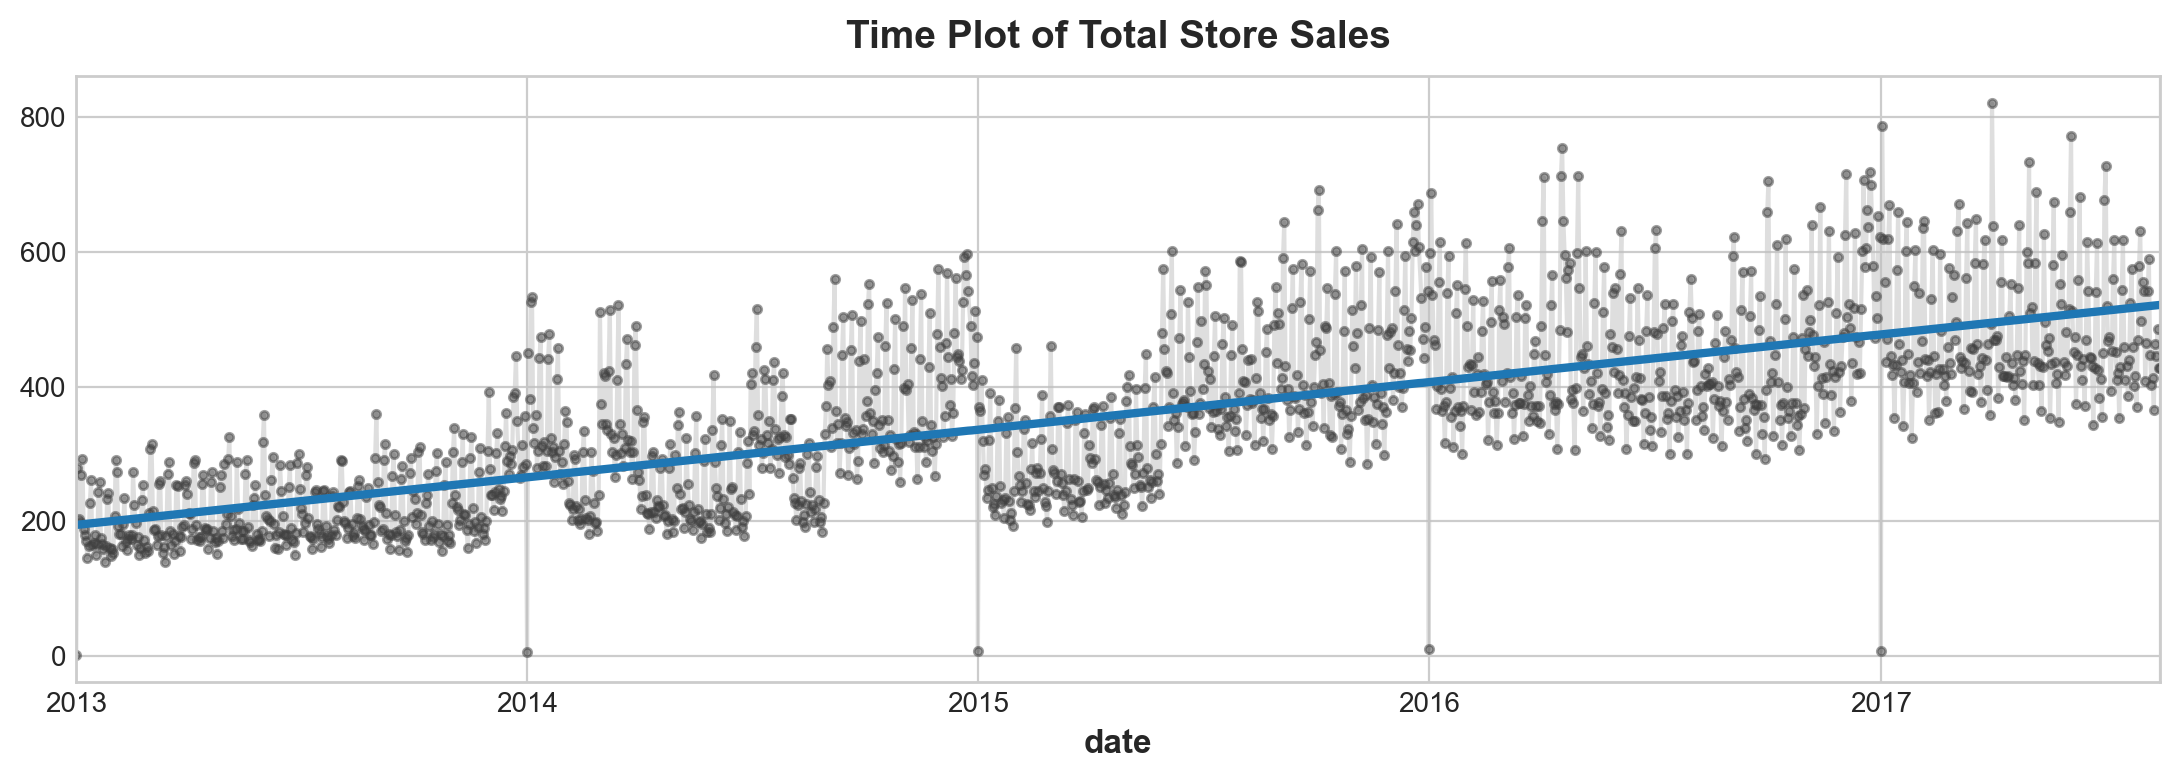

In [22]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

## Fit a lag feature to Store Sales

In [24]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)
# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

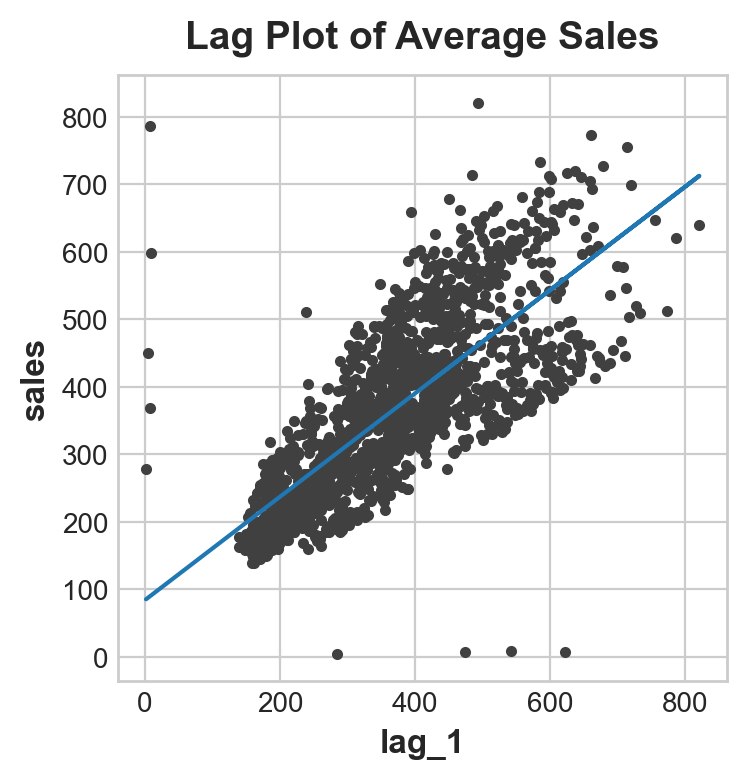

In [25]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');